SID1:530335425, SID2:520602490, SID3:530039187


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import html
# Sklearn lib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score          
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
# Tensorflow lib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, losses
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# Nltk lib
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from gensim.models import Word2Vec
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df = pd.read_csv('training.300000.processed.noemoticon.csv')
df.head()

,sentiment,id,date,query,username,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


change 0 (positive) and 4 (negative) into 0 (positive) and 1 (negative)

In [13]:
data = df[['sentiment', 'text']]
print("unique sentiment value: " + str(data['sentiment'].unique()))
# change 4 into 1
data.loc[data['sentiment'] == 4, 'sentiment'] = 1
print("unique sentiment value: " + str(data['sentiment'].unique()))

unique sentiment value: [0 4]
unique sentiment value: [0 1]


wordcloud (show high frequency words)

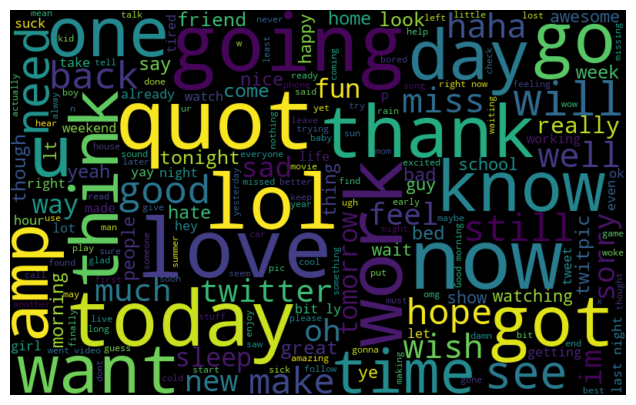

In [14]:
all_words = ' '.join([text for text in data['text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Preprocessing

In [15]:
# text cleaning
def text_cleaning(text):
    # url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = text.apply(lambda x: url_pattern.sub('', x))

    # @ user
    text = text.apply(lambda x: ' '.join(word for word in x.split() if not word.startswith('@')))

    # &quot; --html
    text = text.apply(lambda x: html.unescape(x))

    #remove punctuation
    text = text.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    
    return text

In [16]:
# stopword
def remove_stopword(text):
    stop_words = stopwords.words('english')
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return tokens

In [17]:
# stemming
def stemming(text):
    stemmer = SnowballStemmer('english')
    tokens = []
    for token in text:
        token1 = stemmer.stem(token)
        tokens.append(token1)
    return tokens

In [18]:
# lemmatization
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokens = []
    for token in text:
        token1 =  lemmatizer.lemmatize(token)
        tokens.append(token1)
    return tokens

CNN

In [19]:
#data processing
# only choose test cleaning because others will lower the accuracy
text_CNN = data['text']
text_CNN = text_cleaning(text_CNN) 

# only choose test cleaning because others will reduce the accuracy
#text_CNN = text_CNN.apply(remove_stopword) 
#text_CNN = text_CNN.apply(stemming)
#text_CNN = text_CNN.apply(lemmatization)

In [20]:
X = text_CNN
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
tokenizer = Tokenizer(num_words=5000) # tried 10000, but decrease the acurracy 
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=30) # tried 150, decrease the accuracy
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=30)  # tried 150, decrease the accuracy

CNN random search

In [22]:
param_grid = {
    "dropout_rate": [0.2,  0.5],
    "filter": [224, 256],
    "kernel_size": [3, 7],
}

In [23]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#Creating a CNN model based on the random search
def create_cnn_model(dropout_rate, filter, kernel_size):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=30)) 
    #input_length = 150 or 30: 150 decrease the accuracy
    model.add(Dropout(dropout_rate)) # drops out input units
    model.add(Conv1D(filters=filter,kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define the hyperparameter search space
keras_cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=4, verbose=0)

# Create a RandomizedSearchCV object
# As we have gained the best parameters
# To reduce the run time, we reduced the values of n_iter and cv for validating the correctness of codes
random_search_cnn = RandomizedSearchCV(estimator=keras_cnn_model, param_distributions=param_grid, cv=2, n_iter=5)

# Perform random search
random_search_results = random_search_cnn.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search_results.best_params_)
print("Best Score: ", random_search_results.best_score_)

<timed exec>:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best Parameters:  {'kernel_size': 3, 'filter': 256, 'dropout_rate': 0.5}
Best Score:  0.7925291657447815
Wall time: 19min 6s


CNN best model

In [27]:
%%time
# Using the best params by random search (but results will differ for each time)
# the current output above may not be the best output if re-run it
# but we already confirmed what are best params

#The best params: dropout_rate = 0.2, filter = 224, kernel_size = 3
cnn_best_model = create_cnn_model(dropout_rate = 0.2, filter = 224, kernel_size = 3)
cnn_history = cnn_best_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
3000/3000 [==============================] - 31s 10ms/step - loss: 0.4703 - accuracy: 0.7745 - val_loss: 0.4429 - val_accuracy: 0.7925
Epoch 2/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.4143 - accuracy: 0.8110 - val_loss: 0.4383 - val_accuracy: 0.7960
Epoch 3/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.3802 - accuracy: 0.8305 - val_loss: 0.4425 - val_accuracy: 0.7964
Epoch 4/10
3000/3000 [==============================] - 31s 10ms/step - loss: 0.3507 - accuracy: 0.8461 - val_loss: 0.4603 - val_accuracy: 0.7922
Wall time: 2min


In [28]:
#testing and evaluation
test_loss, test_accuracy = cnn_best_model.evaluate(X_test, y_test)
y_pred = cnn_best_model.predict(X_test)
y_pred = np.round(y_pred) 
#evaluation report
print(classification_report(y_test, y_pred))
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
test_cnn_accuracy=test_accuracy

1875/1875 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.82      0.80     29850
           1       0.81      0.76      0.79     30150

    accuracy                           0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000

Test Loss:  0.4588264226913452
Test Accuracy:  0.7911999821662903


1875/1875 [==============================] - 3s 1ms/step


Text(0.5, 36.72222222222221, 'Predicted label')

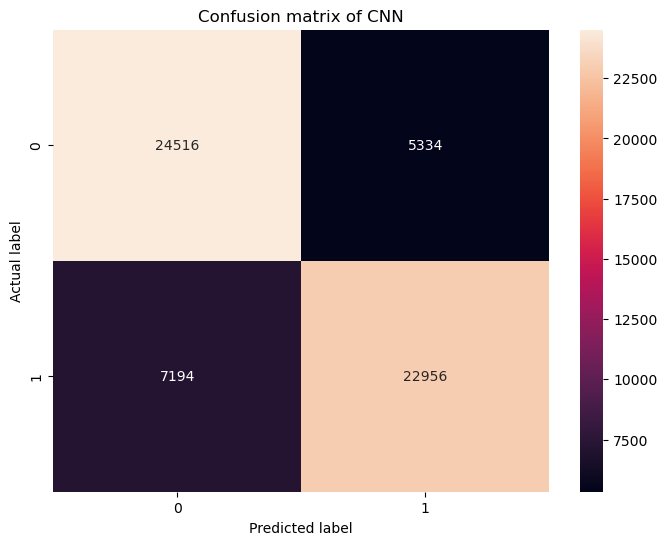

In [29]:
y_pred = (cnn_best_model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix of CNN")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

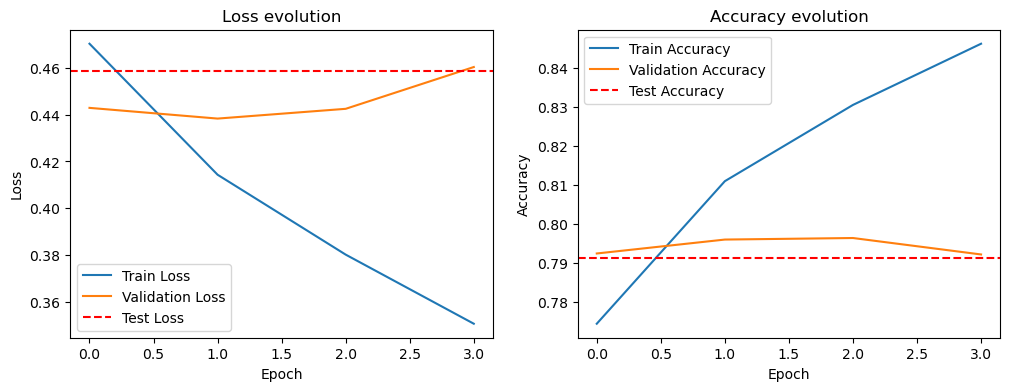

In [30]:
# Create a figure
plt.figure(figsize=(12, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("length 150.png", format='png')

LSTM

In [31]:
# use all preprocessing approches
text_LSTM = data['text']
text_LSTM = text_cleaning(text_LSTM)
# tried text without removing stopwords, perform worser
%time text_LSTM = text_LSTM.apply(remove_stopword) # run time 56.6s
# tried text without stemming and lemmatization, perform worser
%time text_LSTM = text_LSTM.apply(stemming)# run time 21.1s
%time text_LSTM = text_LSTM.apply(lemmatization)# run time 6,7s

Wall time: 57.9 s
Wall time: 20.5 s
Wall time: 6.37 s


In [32]:
X = text_LSTM
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

average words of sentences:  7.935333333333333


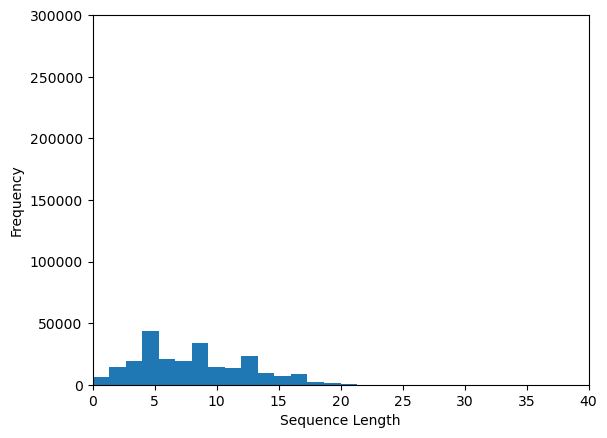

In [33]:
# find an appropriate length
counter = []
for i in X_train:
  counter.append(len(i))
print("average words of sentences: ", sum(counter)/len(X_train))
%matplotlib inline
plt.hist(counter, 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0,40, 0,300000])
plt.show()

In [34]:
# word2vec model to covert words into vectors
word2vec_model = Word2Vec(X_train, vector_size=200, window=7, min_count=1, workers=4)
word_vectors = word2vec_model.wv

In [35]:
# selected sequence length
maxlen = 15

# covert data and feed the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size: " + str(vocab_size))
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = 15)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                        maxlen = 15)

vocab_size: 98510


In [36]:
num_words = len(word_vectors.key_to_index)
embedding_dim = word2vec_model.vector_size
print("embedding_dim: " + str(embedding_dim))

embedding_dim: 200


In [37]:
# create embedding maxtrix for embedding layer
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items(): #117516
  if word in word_vectors: #98509
    embedding_matrix[i] = word_vectors[word]
print("shape of embedding_matrix: " +str(embedding_matrix.shape))

shape of embedding_matrix: (98510, 200)


In [38]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [39]:
# crate a lstm model
def create_lstm_model(units, dropout_rate, recurrent_dropout,dropout_in_lstm, optimizer, learning_rate):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=15, trainable=False),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.LSTM(units, dropout = dropout_in_lstm, recurrent_dropout=recurrent_dropout),
    #tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

LSTM random search

In [40]:
# Define the hyperparameter search space
grid_param = {
    'units': [64, 128],  # Units in LSTM
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],  # Dropout rate
    'dropout_in_lstm': [0.1, 0.2,  0.3], # dropout_in_lstm
    'recurrent_dropout': [0.1, 0.2, 0.3], # recurrent dropout
    'learning_rate': [0.001, 0.005],  # Learning rate optimizer
    'epochs': [8, 10], # Epochs
    'optimizer': [Adam, RMSprop, SGD],
}

In [41]:
%%time
keras_lstm_model = KerasClassifier(build_fn=create_lstm_model, verbose=0)

# Create a RandomizedSearchCV object
# As we have gained the best parameters
# To reduce the run time, we reduced the values of n_iter and cv for validating the correctness of codes
random_search = RandomizedSearchCV(estimator=keras_lstm_model, param_distributions=grid_param, cv=2, n_iter=3)

# Perform random search
random_search_results = random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search_results.best_params_)
print("Best Score: ", random_search_results.best_score_)

<timed exec>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best Parameters:  {'units': 64, 'recurrent_dropout': 0.2, 'optimizer': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>, 'learning_rate': 0.001, 'epochs': 8, 'dropout_rate': 0.2, 'dropout_in_lstm': 0.1}
Best Score:  0.7759583592414856
Wall time: 29min 58s


LSTM Best model

In [42]:
%%time
# Using the best params by random search (but results will differ for each time)
# the current output above may not be the best output if re-run it
# but we already confirmed what are best params
# best params: units = 128, dropout_rate = 0.1, recurrent_dropout = 0.2,
# dropout_in_lstm = 0.2, optimizer = Adam, learning_rate = 0.001
lstm_best_model =  create_lstm_model(units = 128, dropout_rate = 0.1, recurrent_dropout = 0.2,
                                     dropout_in_lstm = 0.2, optimizer = Adam, learning_rate = 0.001)
lstm_best_model.summary()                                     
# fit model
lstm_history = lstm_best_model.fit(X_train, y_train, epochs=8, validation_split=0.2)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 15, 200)           19702000  
                                                                 
 dropout_20 (Dropout)        (None, 15, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               168448    
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 19,870,577
Trainable params: 168,577
Non-trainable params: 19,702,000
_________________________________________________________________
Epoch 1/8
6000/6000 [==============================] - 180s 30ms/step - loss: 0.4999 - accuracy: 0.7537 - val_loss: 0.4783 - val_accuracy: 0.7670
Epoch 2/8
6000/6000 [

In [43]:
test_loss, test_accuracy = lstm_best_model.evaluate(X_test, y_test)
y_pred = lstm_best_model.predict(X_test)
y_pred = np.round(y_pred)

print(classification_report(y_test, y_pred))
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
test_lstm_accuracy=test_accuracy 

1875/1875 [==============================] - 22s 12ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77     29850
         1.0       0.76      0.83      0.79     30150

    accuracy                           0.78     60000
   macro avg       0.78      0.78      0.78     60000
weighted avg       0.78      0.78      0.78     60000

Test Loss:  0.46584922075271606
Test Accuracy:  0.7803333401679993


1875/1875 [==============================] - 22s 12ms/step


Text(0.5, 36.72222222222221, 'Predicted label')

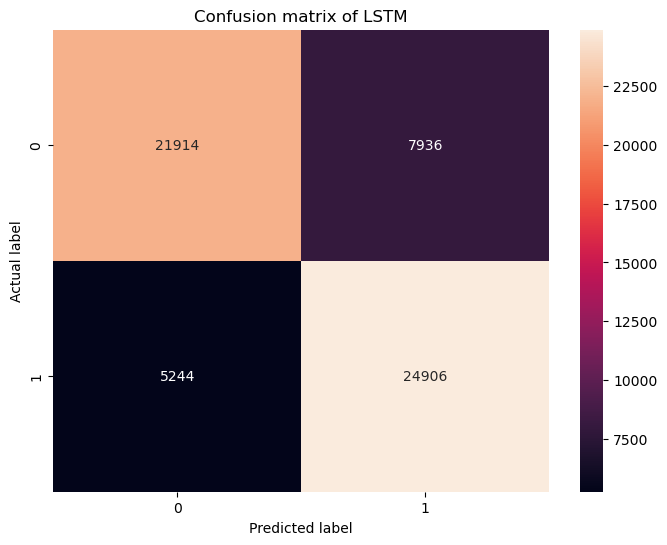

In [44]:
y_pred = (lstm_best_model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix of LSTM")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

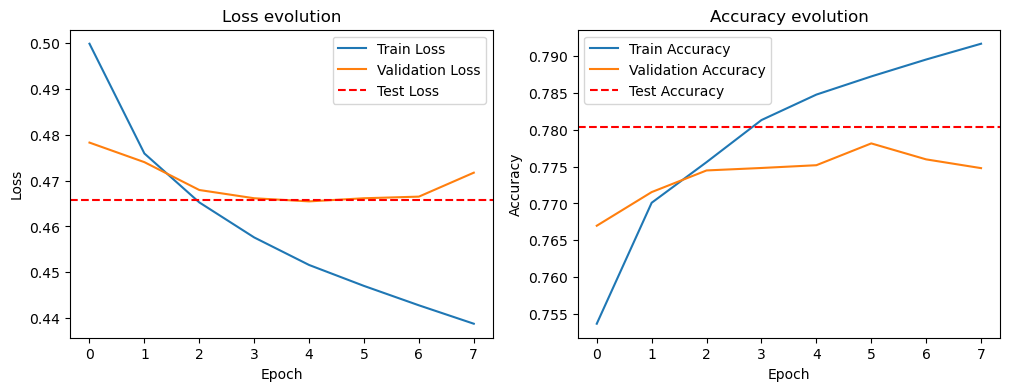

In [45]:
# Create a figure
plt.figure(figsize=(12, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("length 150.png", format='png')

GRU

In [46]:
maxlen = 20 #Ensure all sequences are in fixed size
text_GRU = data['text']
text_GRU = text_cleaning(text_GRU)
%time text_GRU = text_GRU.apply(remove_stopword)# run time 56.6s
# stemming and lemmatization are not important 
# to GRU model as it can automatically identify different forms of words
#text_GRU = text_GRU.apply(stemming)
#text_GRU = text_GRU.apply(lemmatization)

Wall time: 54.2 s


In [47]:
# Split train and test data to avoid information leakage (same data for all models)
X = text_GRU
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [48]:
 # Train a Word2Vec model to transform words into vectors
word2vec_model = Word2Vec(X_train, vector_size=300, window=5, min_count=1, workers=8)
word_vectors = word2vec_model.wv

In [49]:
# Turning a text into sequence of integers
tokenizer = Tokenizer(oov_token="unknown")
tokenizer.fit_on_texts(X_train)#Only be fit on the training data

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = maxlen) 
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = maxlen)

In [50]:
# Converting training and testing labels to data type and shape
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [51]:
## embedding matrix.
vocab_size = len(word_vectors.key_to_index) + 2 # Padding token and the unknown token
embedding_dim = word2vec_model.vector_size
print("embedding_dim: "+str(embedding_dim)) 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2vec_model.wv.key_to_index.items(): # iterates through each word in Word2Vec model's vocabulary
    embedding_matrix[i] = word2vec_model.wv[word]
print("embedding_matrix: "+str(embedding_matrix.shape))
embedding_matrix[1] = np.random.uniform(-1, 1, embedding_dim) # 2D bynot array where each row represents a word in vocabulary

embedding_dim: 300
embedding_matrix: (146132, 300)


In [52]:
# This is a custom GRU model with one Embedding layer, 
# two GRU layers within dropout, 
# one Dense layer with sigmoid activation
class myGRU(keras.Model):                               
    def __init__(self, units, dropout_rate, vocab_size, embedding_dim, embedding_matrix):
        super(myGRU, self).__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim, 
                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                          trainable=False,input_length=maxlen)

       
        self.gru0 = layers.GRU(units, dropout=dropout_rate, return_sequences=True)
        self.gru1 = layers.GRU(units, dropout=dropout_rate)

        self.outlayer = layers.Dense(1)
        
          
    def call(self, inputs, training=None):               
        x = self.embedding(inputs)
        x = self.gru0(x, training=training)
        x = self.gru1(x, training=training)
        x = self.outlayer(x)
        prob = tf.sigmoid(x)

        return prob

GRU random search

In [53]:
param_grid = {
    'units': [64, 128],
    'optimizer': ['adam'],
    'dropout_rate': [0.1, 0.2, 0.5], # The different parameters tuned
    'batch_size': [32, 64]
}

In [54]:
#RandomSearch for Best Parameters
def random_search_GRU(units, dropout_rate, optimizer='adam'):
    model = myGRU(units, dropout_rate,vocab_size, embedding_dim, embedding_matrix)
    model.compile(
        optimizer=optimizer,
        loss=tf.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [55]:
%%time
# Using the best params by random search (but results will differ for each time)
# the current output above may not be the best output if re-run it
# but we already confirmed what are best params
GRU_model = KerasClassifier(build_fn=random_search_GRU, verbose=0)
# As we have gained the best parameters
# To reduce the run time, we reduced the values of n_iter and cv for validating the correctness of codes
random_search = RandomizedSearchCV(estimator=GRU_model, param_distributions=param_grid, n_iter=5, cv=2)
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

<timed exec>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best Parameters:  {'units': 128, 'optimizer': 'adam', 'dropout_rate': 0.1, 'batch_size': 32}
Best Score:  0.7092083394527435
Wall time: 23min 45s


GRU best model

In [56]:
%%time
# The best configuration of GRU model
GRU_best_model = myGRU(units = 64, dropout_rate = 0.2,vocab_size = vocab_size,
                    embedding_dim = embedding_dim, embedding_matrix = embedding_matrix)
# Compile the model
GRU_best_model.compile(optimizer="adam",
                   loss=tf.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

# Fit the model
GRU_history = GRU_best_model.fit(X_train, y_train, 
                         validation_split=0.2, 
                         epochs=10, 
                         batch_size=32)
GRU_best_model.summary()

Epoch 1/10
6000/6000 [==============================] - 165s 27ms/step - loss: 0.5847 - accuracy: 0.6797 - val_loss: 0.5643 - val_accuracy: 0.6987
Epoch 2/10
6000/6000 [==============================] - 159s 27ms/step - loss: 0.5483 - accuracy: 0.7126 - val_loss: 0.5349 - val_accuracy: 0.7252
Epoch 3/10
6000/6000 [==============================] - 158s 26ms/step - loss: 0.5343 - accuracy: 0.7243 - val_loss: 0.5273 - val_accuracy: 0.7318
Epoch 4/10
6000/6000 [==============================] - 160s 27ms/step - loss: 0.5268 - accuracy: 0.7306 - val_loss: 0.5261 - val_accuracy: 0.7312
Epoch 5/10
6000/6000 [==============================] - 161s 27ms/step - loss: 0.5204 - accuracy: 0.7341 - val_loss: 0.5201 - val_accuracy: 0.7378
Epoch 6/10
6000/6000 [==============================] - 177s 30ms/step - loss: 0.5165 - accuracy: 0.7389 - val_loss: 0.5176 - val_accuracy: 0.7407
Epoch 7/10
6000/6000 [==============================] - 191s 32ms/step - loss: 0.5125 - accuracy: 0.7409 - val_loss: 0

In [57]:
test_loss, test_accuracy = GRU_best_model.evaluate(X_test, y_test,)
y_pred = GRU_best_model.predict(X_test)
y_pred = np.round(y_pred) 
# A classification report with various metrics
print(classification_report(y_test, y_pred,))
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
test_gru_accuracy=test_accuracy

1875/1875 [==============================] - 29s 15ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72     29850
         1.0       0.72      0.80      0.76     30150

    accuracy                           0.74     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.74      0.74     60000

Test Loss:  0.5154914259910583
Test Accuracy:  0.7410666942596436


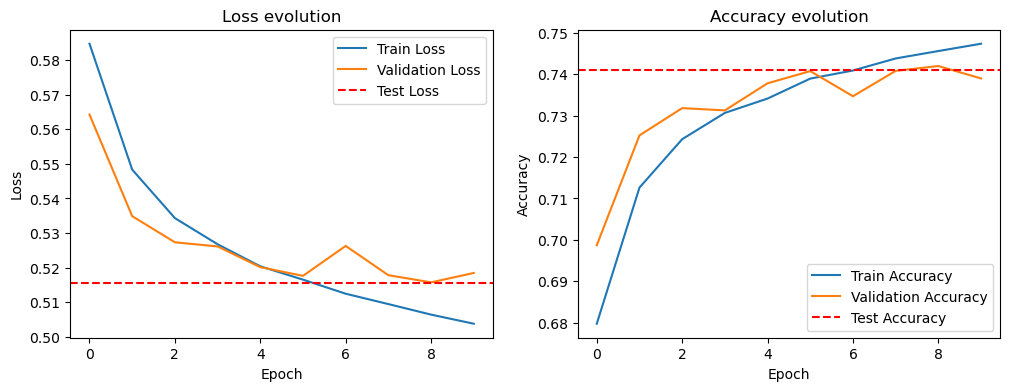

In [58]:
# Create a figure
plt.figure(figsize=(12, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(GRU_history.history['loss'], label='Train Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(GRU_history.history['accuracy'], label='Train Accuracy')
plt.plot(GRU_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("length 150.png", format='png')

1875/1875 [==============================] - 27s 14ms/step


Text(0.5, 36.72222222222221, 'Predicted label')

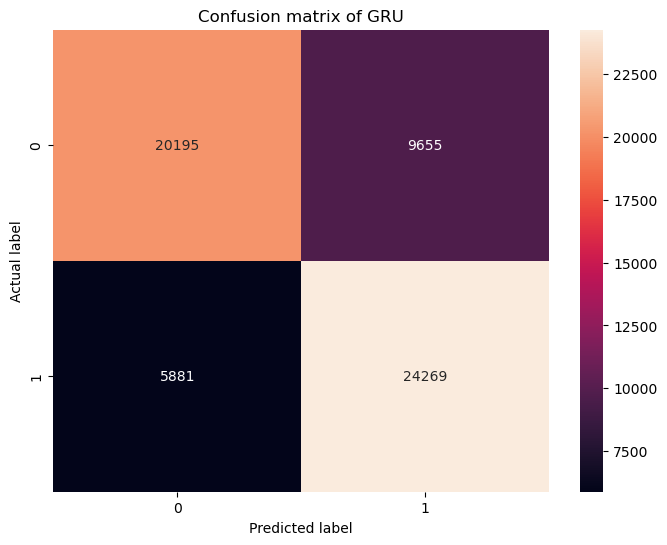

In [59]:
# PLot for a confusion matrix
y_pred = (GRU_best_model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix of GRU")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

Model Comparison(Accuracy)

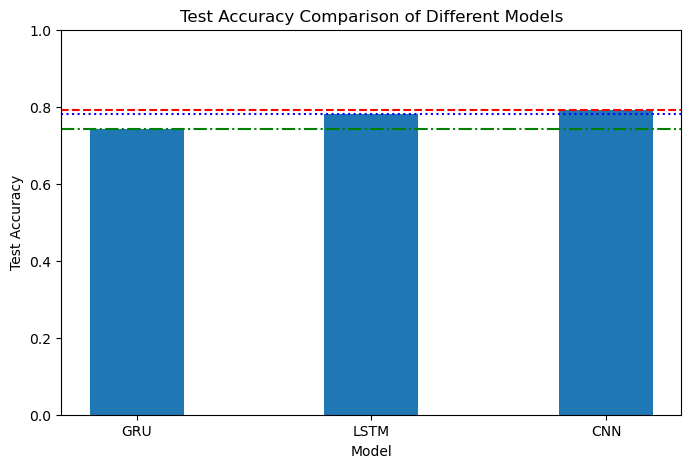

In [60]:
# Model comparison
models = ['GRU', 'LSTM', 'CNN']

accuracy = [test_gru_accuracy, test_lstm_accuracy, test_cnn_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracy,width=0.4)

plt.axhline(y=test_cnn_accuracy, color='r', linestyle='--', label='Test CNN Accuracy')
plt.axhline(y=test_lstm_accuracy, color='b', linestyle=':', label='Test LSTM Accuracy')
plt.axhline(y=test_gru_accuracy, color='g', linestyle='-.', label='Test GRU Accuracy')

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison of Different Models')
plt.ylim([0.0, 1.0])
plt.show()